# Purpose

This project aims to demystify neural networks by guiding you through building one from scratch. We'll train our neural network on the MNIST Dataset, which comprises 70,000 handwritten digit images (0-9), each sized at 28x28 pixels. By the end of this tutorial, you'll have a trained model capable of recognizing digits with an accuracy exceeding 90%.

## Introduction to Neural Networks

Neural networks come in various architectures, each suited for different tasks. For this project, we'll use a simple feedforward neural network to keep things straightforward. Here's the structure we'll implement:

* Input Layer: 784 neurons, corresponding to the 28x28 pixels of each MNIST image.
* Hidden Layer: 16 neurons. While this number is arbitrary, it strikes a balance between model simplicity and training efficiency. Increasing the number or size of hidden layers can enhance performance but will require more computational resources.
* Output Layer: 10 neurons, each representing one of the digits from 0 to 9.

This setup is designed for multi-class classification, where the network predicts the most probable class (digit) for a given input image.

## Step 1 Load the dataset
---

### 1.1 Download Dataset

We'll use the `openml` library to fetch the MNIST dataset. This library simplifies dataset management, allowg us to download and access data seamlessly.

In [5]:
import openml
import numpy as np
import matplotlib.pyplot as plt

# Download MNIST dataset from OpenML
mnist = openml.datasets.get_dataset(554)    # ID for MNIST

### 1.2 Extract Data and Labels

After downloading, we'll extract the feature data (`x`) and labels (`y`):

* x: Contains the pixel data for each image, reshaped into a 784-dimensional vector (28x28 pixels).
* y: Contains the integer labels (0-9) corresponding to each image

We'll also normalize the pixel values to the range [0, 1] for faster and more stable training.

In [6]:
# Extract data and labels from dataset
x, y, _, _ = mnist.get_data(target=mnist.default_target_attribute)

# Normalize pixel values and reshape data
x = x.to_numpy().reshape(-1, 28 * 28).astype(np.float32) / 255.0
y = y.astype(int)

### 1.3 Split Data into Training and Testing Sets

To evaluate our model's performance, we'll divid the dataset into

* Training Set: 60,000 images used to train the neural network.
* Testing set: 10,000 images used to asses the model's accuracy.

In [7]:
# Split data into training and testing sets
x_train, x_test = x[:60000].T, x[60000:].T  # Transpose to make (784, 60000)
y_train, y_test = y[:60000], y[60000:]

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


x shape: (70000, 784)
y shape: (70000,)
x_train shape: (784, 60000), x_test shape: (784, 10000)
y_train shape: (60000,), y_test shape: (10000,)


### 1.4 Visualizing Sample Space

Visualizing a subset of the dataset helps in understanding the data we're working with. We'll display the first 25 images from the training set along with their labels.

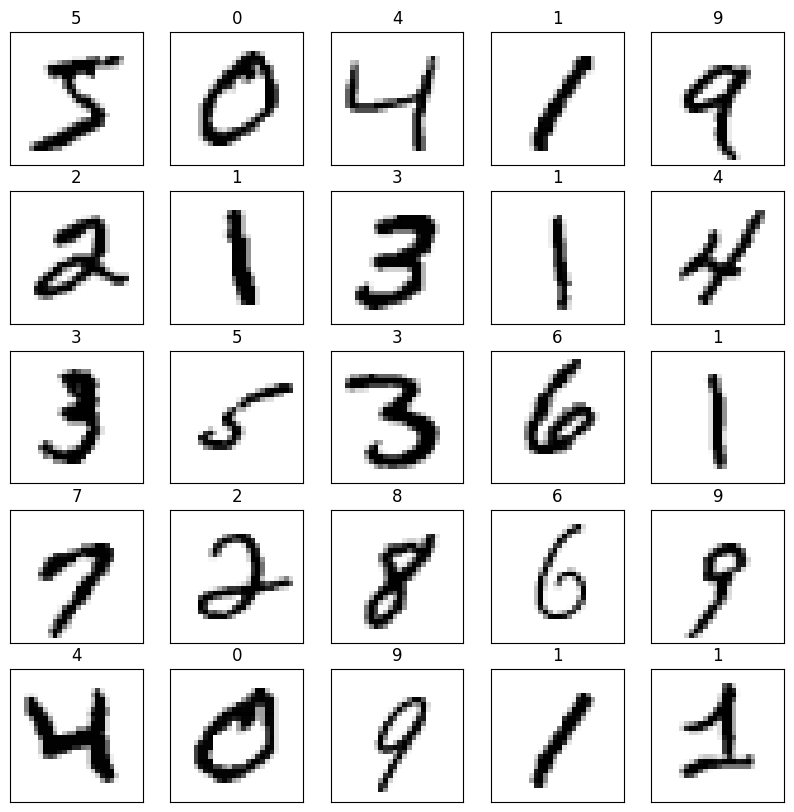

In [8]:
# Plot the first 25 images from the training set
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1) # 5 rows and 5 columns
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.grid(False) # Remove gridlines
    plt.imshow(x_train[:, i].reshape(28, 28), cmap=plt.cm.binary)  # Reshape to (28,28)
    plt.title(y_train[i])
    
plt.show()

## Step 2 Weights and Biases
---

### 2.1 Initializing Weights and Biases

Neural networks rely on weights and biases to learn patterns in data. Proper initialization is crucial for effective training.

* Weights: determine the strength of connections between neurons
* Biases: allow the activation functions t obe shifted, enabling the network to fit data better


In [9]:
'''
Generate values from a standard normal distribution (mean 0, variance 1)

Multiply values by 0.01 to keep weights small and help with training stability

A row corresponds to the connections between all neurons in the first layer and
    a single neuron in the next layer (calculating activation for)

A column corresponds to all weights coming out of a particular neuron in first layer

Parameters:
- layer_dims: list containing the amount of neurons in each layer

Returns:
- weights (dict): Dictionary containing initialized weight matrices.
- biases (dict): Dictionary containing initialized bias vectors.
'''
def initialize_parameters(layer_dims):

    # Arrays to store our list of weights and biases
    weights = []
    biases = []

    # Loop through number of layers for initialization
        # Weights should be random variables
        # Biases should be set to 0
    for i in range(1, len(layer_dims)):

        # Initialize weights with small random values scaled by the square root of the number of input connections (He initialization)
        w = np.random.randn(layer_dims[i], layer_dims[i - 1]) * np.sqrt(2. / layer_dims[i - 1])

        # Initialize biases to zeros
        b = np.zeros((layer_dims[i], 1))

        weights.append(w)
        biases.append(b)

    return weights, biases

### Step 2.2 Visualizing the Neural Network

Understanding the architecture visually can provide clarity on how data flows through the network. We'll create a simplified diagram of our neural network.

* Input Layer: Represents the 784 input neurons (pixels). Due to space constraints, only a subset is displayed with an ellipsis (...) indicating the hidden neurons.
* Hidden Layer: Contains 16 neurons that process the inputs.
* Output Layer: Comprises 10 neurons corresponding to the digits 0-9.

Connections: Lines between neurons signify the weighted connections. Faint lines indicate a fully connected network.

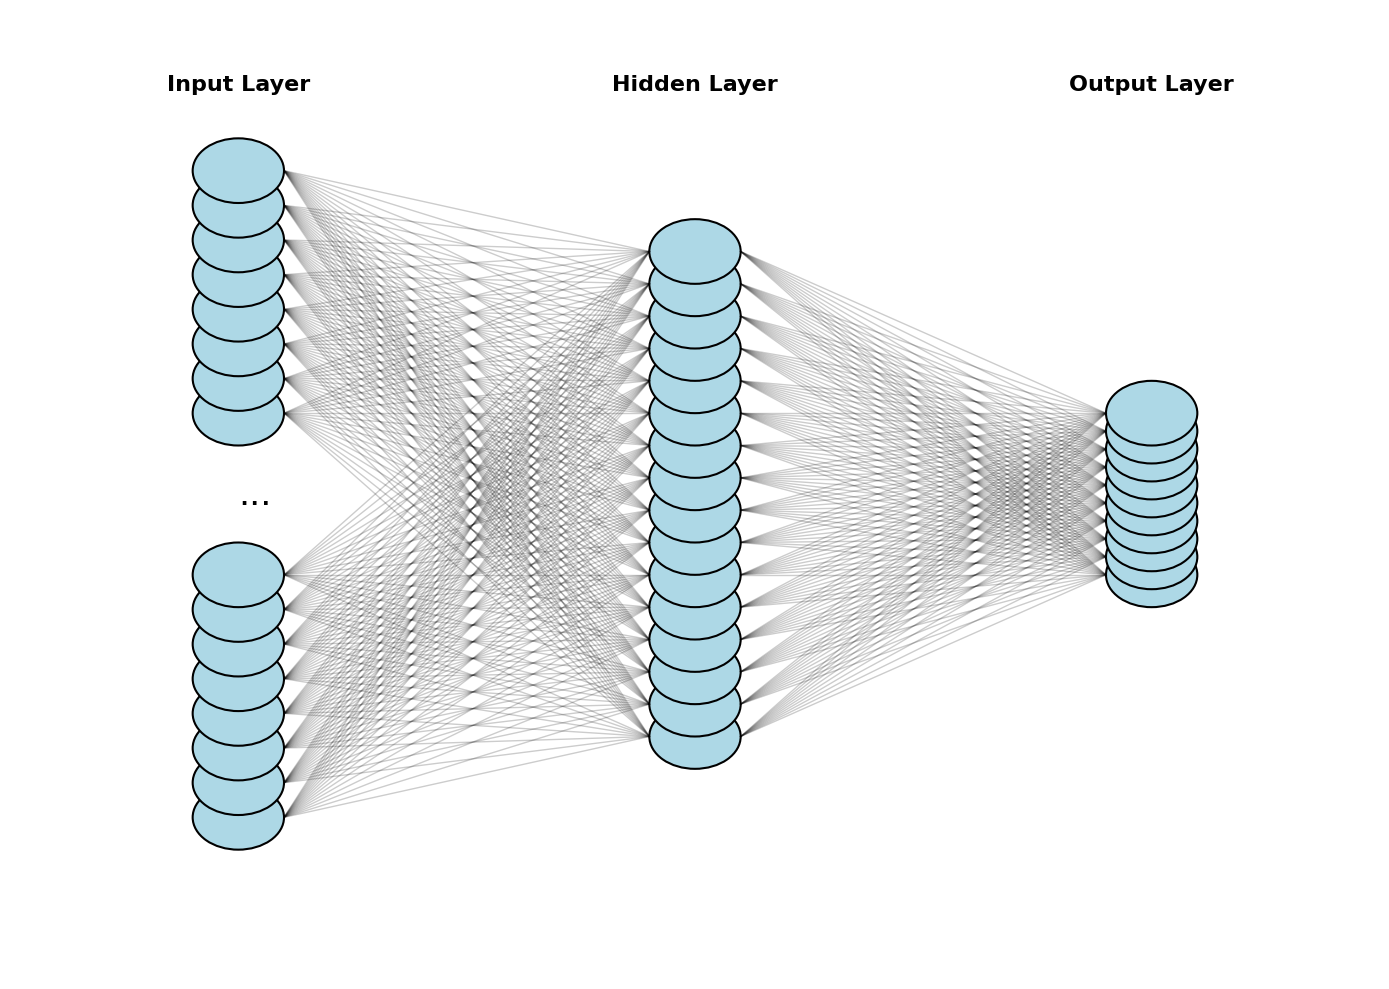

In [10]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

def draw_neural_network(input_size, hidden_size, output_size, max_display=16):
    
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.axis('off')

    # Spacing parameters to distribute neurons more evenly
    neuron_size = 0.4  # Circle size for each neuron
    neuron_color = 'lightblue'
    
    # Split the input layer for max_display neurons
    if input_size > max_display:
        # Show the first and last few neurons with a '...' in the middle
        displayed_neurons = max_display // 2
        input_layer = [(2, i) for i in np.linspace(2, 5, displayed_neurons)] + \
                      [(2, i) for i in np.linspace(7, 10, displayed_neurons)]
    else:
        input_layer = [(2, i) for i in np.linspace(2, 10, input_size)]
        
    hidden_layer = [(6, i) for i in np.linspace(3, 9, hidden_size)]
    output_layer = [(10, i) for i in np.linspace(5, 7, output_size)]

    # Draw neurons with distinct color and size
    for layer in [input_layer, hidden_layer, output_layer]:
        for neuron in layer:
            circle = patches.Circle(neuron, neuron_size, fill=True, color=neuron_color, ec='k', lw=1.5)
            ax.add_patch(circle)

    # Draw connections with transparency for better clarity
    for i in input_layer:
        for h in hidden_layer:
            ax.plot([i[0]+0.4, h[0]-0.4], [i[1], h[1]], 'k-', alpha=0.2, lw=1)
    for h in hidden_layer:
        for o in output_layer:
            ax.plot([h[0]+0.4, o[0]-0.4], [h[1], o[1]], 'k-', alpha=0.2, lw=1)

    # Add '...' to indicate skipped neurons with better positioning and size
    if input_size > max_display:
        ax.text(2, 6, '...', fontsize=25, verticalalignment='center', color='black')

    # Layer labels with improved styling
    ax.text(2, 11, 'Input Layer', horizontalalignment='center', fontsize=16, fontweight='bold')
    ax.text(6, 11, 'Hidden Layer', horizontalalignment='center', fontsize=16, fontweight='bold')
    ax.text(10, 11, 'Output Layer', horizontalalignment='center', fontsize=16, fontweight='bold')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
draw_neural_network(input_size=784, hidden_size=16, output_size=10)



## Step 3: Activation and Loss Functions
---

### 3.1 Sigmoid Activation Function

The sigmoid function introduces non-linearity into the network, enabling it to learn complex patterns. The function squashes input values into a range between 0 and 1, while keeping relative scale consistent and is commonly used in hidden layers.
$$\sigma (z) = \frac{1}{1 + e^{-z}}$$

In [8]:
'''
Applies the sigmoid activation function.

Parameters:
- z (np.array): Input array.

Returns:
- np.array: Output after applying sigmoid.
'''
def sigmoid(z):

    return 1 / (1 + np.exp(-z))


#### 3.1.1 Sigmoid Function Visualization

This will allow us to see how values are squished between 0 and 1 on the y-axis while extending on the x-axis. This function has largely been replaced by a ReLU function in practice, but we'll stick with it today.

* S-shape Curve: The sigmoid function smoothly maps any input value to a value between 0 and 1.
* Threshold Behavior: Values around 0 are mapped to 0.5, while large positive or negative inputs approach 1 or 0, respectively.

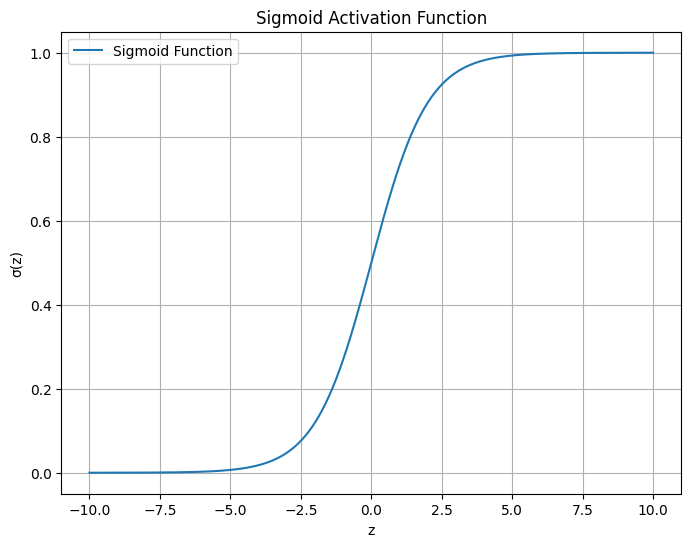

In [9]:
# Generate input values
z = np.linspace(-10, 10, 1000)
sigmoid_z = sigmoid(z)

# Plot sigmoid function
plt.figure(figsize=(8, 6))
plt.plot(z, sigmoid_z, label='Sigmoid Function')
plt.title('Sigmoid Activation Function')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.grid(True)
plt.legend()
plt.show()


### 3.2 Sigmoid Derivative

The derivative of the function above is necessary for a concept known as backpropagation that we'll get to later. For now, know that the derivative tells us the slope of a point on the sigmoid function.

$$\sigma'(a) = \sigma (a) \cdot (1 - \sigma(a))$$

In [10]:
'''
Computes the derivative of the sigmoid function.

Parameters:
- a (np.array): Output from the sigmoid function.

Returns:
- np.array: Derivative of sigmoid.
'''
def sigmoid_derivative(a):

    return a * (1 - a)


#### 3.2.1 Sigmoid Derivative Visualization

This will allow us to see what the derivative looks like.

* Peak at 0: The derivative is highest when the input to sigmoid is 0.
* Symmetric Decay: The derivative decreases as the input moves away from 0, approaching 0 for large positive or negative inputs.

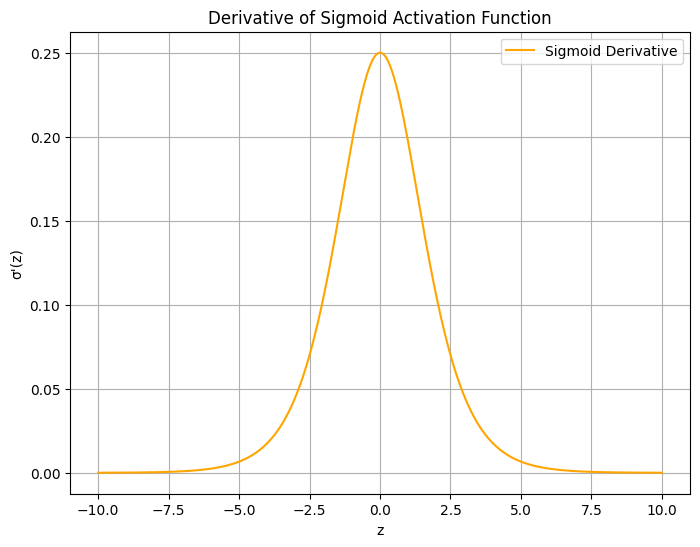

In [11]:
# Compute derivative
sigmoid_derivative_z = sigmoid_derivative(sigmoid_z)

# Plot derivative
plt.figure(figsize=(8, 6))
plt.plot(z, sigmoid_derivative_z, label='Sigmoid Derivative', color='orange')
plt.title('Derivative of Sigmoid Activation Function')
plt.xlabel('z')
plt.ylabel("σ'(z)")
plt.grid(True)
plt.legend()
plt.show()


### 3.3 Softmax Function

The softmax function converts raw scores into probabilities, making it suitable for multi-class classification in the output layer.

* Probability Distribution: Softmax converts raw scores into probabilities that sum to 1.
* Exponentiation: Higher scores get exponentially more weight, making them more probable.

$$softmax(z_j) = \frac{e^{z_j}}{\sum_{k = 1}^Ce^{z_k}}$$

In [12]:
'''
Transform raw scores into probabilities that sum to 1

subtract max value from z to ensure that the largest value in z becomes 0
    prevents large exponentials from occuring while preserving relative differences

Parameters:
- z (np.array): Input array of shape (output_size, number_of_samples).

Returns:
- np.array: Output probabilities after applying softmax.
'''
def softmax(z):

    # Subtract max for numerical stability
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    
    # Return probability distribution over the classes
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)


#### 3.3.1 Softmax Visualization

Here are some examples using 2.0, 1.0, and 0.1. The softmax function will turn these scores into probabilities that total to 1.

Sum of probabilities: 1.0


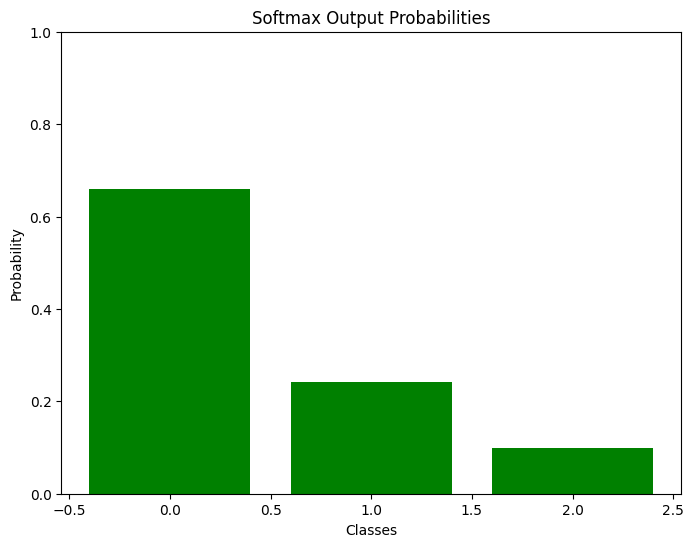

In [13]:
'''
Plots softmax probabilities for a given set of scores.

Parameters:
- scores (list or np.array): Raw scores.

Returns:
- None
'''
def plot_softmax(scores):
    
    scores = np.array(scores)
    probabilities = softmax(scores.reshape(-1, 1)).flatten()
    print("Sum of probabilities:", np.sum(probabilities))

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(scores)), probabilities, color='green')
    plt.title('Softmax Output Probabilities')
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.show()

# Example usage:
sample_scores = [2.0, 1.0, 0.1]
plot_softmax(sample_scores)


### 3.4 Cross-Entropy Loss

The loss function measures how well the neural network's predictions match the actual labels. For multi-class classification, **cross-entropy loss** is commonly used.

$$ L= - \frac{1}{m}\sum_{i = 1}^m \sum_{j = 1}^Cy_j^{(i)}log(a_{2, j}^{(i)}) $$

Where:
* $m$ = number of samples
* $C$ = number of classes
* $y_j^{(i)}$ = true lable (1 if correct, 0 otherwise)
* $a_{2, j}^{(i)}$ = predicted probability for class $j$

In [14]:
'''
Calculate the loss during training
    (how far off the model's prediction is from the correct label)
    DOES NOT DO PREDICTION
    
Use cross-entropy loss for multi-class classification
    (popular because it penalizes incorrect predictions with large probabilities very harshly)

Full loss for batch data: average of the cross-entropy loss over all samples in the batch

Parameters:
- a2: output of the network after softmax (shape: output_size, number_of_samples)
- y: true labels (shape: number_of_samples,)
    
Returns:
- loss: cross-entropy loss
'''
def compute_loss(a2, y):

    # Number of samples
    m = y.shape[0]

    # small constant to prevent log(0)
    epsilon = 1e-15

    # Clip a2 to prevent log(0) leading to unknown behavior
    a2_clipped = np.clip(a2, epsilon, 1 - epsilon)

    '''
    Compute cross-entropy loss
    Single sample: L = -log(a_{2, j})
        j is the index of the correct class (true label)
    Then, find the average over batch
    '''
    log_probability = -np.log(a2_clipped[y, np.arange(m)])    # Log of correct class probability
    loss = np.sum(log_probability) / m                        # Average loss across all samples

    return loss

## Step 4: Forward and Backward Propagation
---

### 4.1 Forward Propagation

Computes the output of the network by sequentially processing the input through each layer. Here's how it works:

**1. Input Layer to Hidden Layer**:
* Compute the weighted sum `z1` of inputs and biases.
$$ z_1 = W_1 \cdot x + b_1 $$
* Where:
    * $W_1$ = weight matrix connecting the input layer to the hidden layer.
    * $x$ = input data.
    * $b_1$ = bias vector for the hidden layer.

* Apply the sigmoid activation function to obtain activations `a1`.

$$ a_1 = \sigma(z_1) $$

**2. Hidden Layer to Output Layer:**
*  Compute the weighted sum `z2` of hidden activations and biases.
$$ z_2 = W_2 \cdot a_1 + b_2 $$
* Where:
    * $W_2$ = weight matrix connecting the hidden layer to the output layer.
    * $b_2$ = bias vector for the output layer.

* Apply the softmax activation function to obtain output probabilitites `a2`.

$$ a_2 = softmax(z_2) $$

In [15]:
'''
Forwardpropagation

Take input data and pass through network to compute output and intermediate values
    Output is the predicted probabilities the network comes up with

    Input Layer -> Hidden Layer (Sigmoid activation) -> Output Layer (Softmax activation)

Arguments:
- x: input data (shape: number_of_samples, input_size)
- weights: dictionary containing the current weights w1 (input -> hidden) and w2 (hidden -> output)
- biases: dictionary containing the current biases b1 (hidden) and b2 (output)

Returns:
- a2: activations at output layer (probability distribution over classes)
- cache: dictionary containing z1, a1, z2, a2 needed for backpropagation
'''
def forward_propagation(x, weights, biases):

    # z1 is the pre-activation values for the hidden layer
    z1 = np.dot(weights['w1'], x) + biases['b1']

    # a1 is the Sigmoid activation for the hidden layer (squishes z1 between 0 and 1)
    a1 = sigmoid(z1)

    # z2 is the pre-activation values for the output layer
    z2 = np.dot(weights['w2'], a1) + biases['b2']

    # a2 is the softmax activation for the output layer (probability distribution function)
    a2 = softmax(z2)

    cache = {
        'z1' : z1,
        'a1' : a1,
        'z2' : z2,
        'a2' : a2
    }

    return a2, cache

### 4.2 Backward Propagation

Backward propagation (backpropagation) is the process by which the neural network learns by updating its weights and biases based on the error of its predictions

It involves calculating the gradients of the loss function with respect to each parameter and adjusting them to minimize the loss.

1. Number of samples ($m$):
    * Determines the batch size for gradient calculations.
2. Retrieve cached values:
    * $a_1$ = activations from the hidden layer.
    * $a_2$ = activations from the output layer.
3. One-hot encoding of labels:
    * Converts integer labels into binary vectors for multi-class classification.
    * Example: Label `3` becomes `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.
4. Compute output layer error ($\delta_2$):
    * $ \delta_2 = a_2 - y_{one-hot} $
    * Represents the difference between predicted probabilities and actual labels.
5. Compute gradients for output layer:
    $$ \frac{\partial L}{\partial W_2} = \frac{1}{m}\delta_2 \cdot a_1^T $$
    $$ \frac{\partial L}{\partial b_2}  = \frac{1}{m}\sum \delta_2 $$
* Where:
    * $dw_2$ = Gradient of the loss with respect to $W_2$.
    * $db_2$ = Gradient of the loss with respect to $b_2$.
6. Backpropagate error to hidden layer ($\delta_1$):
    $$ \delta_1 = W_2^T \cdot \delta_2 \circ \sigma'(z_1) $$
    * $W_2^T \cdot \delta_2$ = Propagates the error back to the hidden layer.
    * $\circ$: Element-wise multiplication with the derivative of the sigmoid function.
7. Compute gradients for the hidden layer:
    $$ \frac{\partial L}{\partial W_1} = \frac{1}{m}\delta_1 \cdot x^T $$
    $$ \frac{\partial L}{\partial b_1} = \frac{1}{m}\sum \delta_1 $$
* Where:
    * $dw_1$ = Gradient of the loss with respect to $W_1$.
    * $db_1$ = Gradient of the loss with respect to $b_1$.
8. Store gradients:
    * Store the final gradients in a dictionary for easy access during parameter updates.

In [16]:
'''
Backpropagation

Overall Goal

    Compute gradient of loss function with respect to each weight and bias
        Gradients tell us how to adjust weights and biases to minimize loss
            walk down the inverse gradient and find local minima of loss function
            As loss decreases, our model gets better at identifying numbers

    Compute error at output layer
        (how far the guess was compared to the actual label)
    Propagate error backward through the network to see how each weight and bias contributed to the error
    Use the errors to update the weights and biases via gradient descent

Gradients

    Gradients are the generalization of the derivative to function of multiple variables
        Vector that contains partial derivatives with respect to all variables of the function
        Tells us the direction of steepest ascent for the loss
            Gradient Descent: doing the inverse to decrease the loss by steepest descent

Arguments:
- x: input data (shape: number_of_samples, input_size)
- y: true labels (shape: number_of_samples,)
- cache: dictionary containing z1, a1, z2, a2 (from forward propagation)
- weights: dictionary containing w1 and w2
    
Returns:
- gradients: dictionary containing the gradients with respect to w1, w2, b1, b2
'''
def back_propagation(x, y, cache, weights):

    # Number of samples
    m = y.shape[0]

    '''
    Retrieve cached values from forward propagation
        a1: activations at hidden layer (after applying sigmoid)
            These become the input for the next layer (output)
        a2: activations at output layer (probability distribution over classes)
    '''
    a1, a2 = cache['a1'], cache['a2']

    '''
    One-hot encode labels to be compatible with function
    Initialize matrix filled with 0s
    '''
    y_one_hot = np.zeros_like(a2)

    '''
    Generate array of indices corresponding to number of samples
    y = 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    '''
    y_one_hot[y, np.arange(m)] = 1

    # Step 1: Output Layer Error (Softmax + Cross-Entropy Derivative)
    delta2 = a2 - y_one_hot # Error at output layer (probability distribution - actual label)

    # Step 2: Gradient of weights and biases for the output layer
    dw2 = np.dot(delta2, a1.T) / m # Gradient of weights (dot product between error and hidden layer activations) / m
    db2 = np.sum(delta2, axis=1, keepdims=True) / m # Gradient of biases (summation of errors for each output) / m

    # Step 3: Backpropagate the error to the hidden layer
    da1 = np.dot(weights['w2'].T, delta2)  # Error at hidden layer before applying Sigmoid derivative

    # Step 4: Sigmoid derivative to the error at the hidden layer
    delta1 = da1 * sigmoid_derivative(cache['a1'])

    # Step 5: Gradient of weights and biases for hidden layer
    dw1 = np.dot(delta1, x.T) / m  # Gradient loss with respect to weights connecting the input layer to hidden layer
    db1 = np.sum(delta1, axis=1, keepdims=True) / m    # Graident biases between input layer and hidden layer

    # Store gradients in a dictionary for later use
    gradients = {
        'dw1' : dw1,
        'db1' : db1,
        'dw2' : dw2,
        'db2' : db2
    }

    return gradients

### 4.3 Visualize Propagation

To visualize forward propagation, we'll illustrate how a probability distribution is compute by flowing through the network.
* Forward pass:
    * Data flows from the input layer through the hidden layer to the output layer.
    * Activations are computed at each layer.

To visualize backpropagation, we'll illustrate how gradients flow through the network and how they influence weight updates.
* Backward Pass:
    * Gradients of the loss with respect to each parameter are computed.
    * Gradients flow backward from the output layer to the hidden layer.


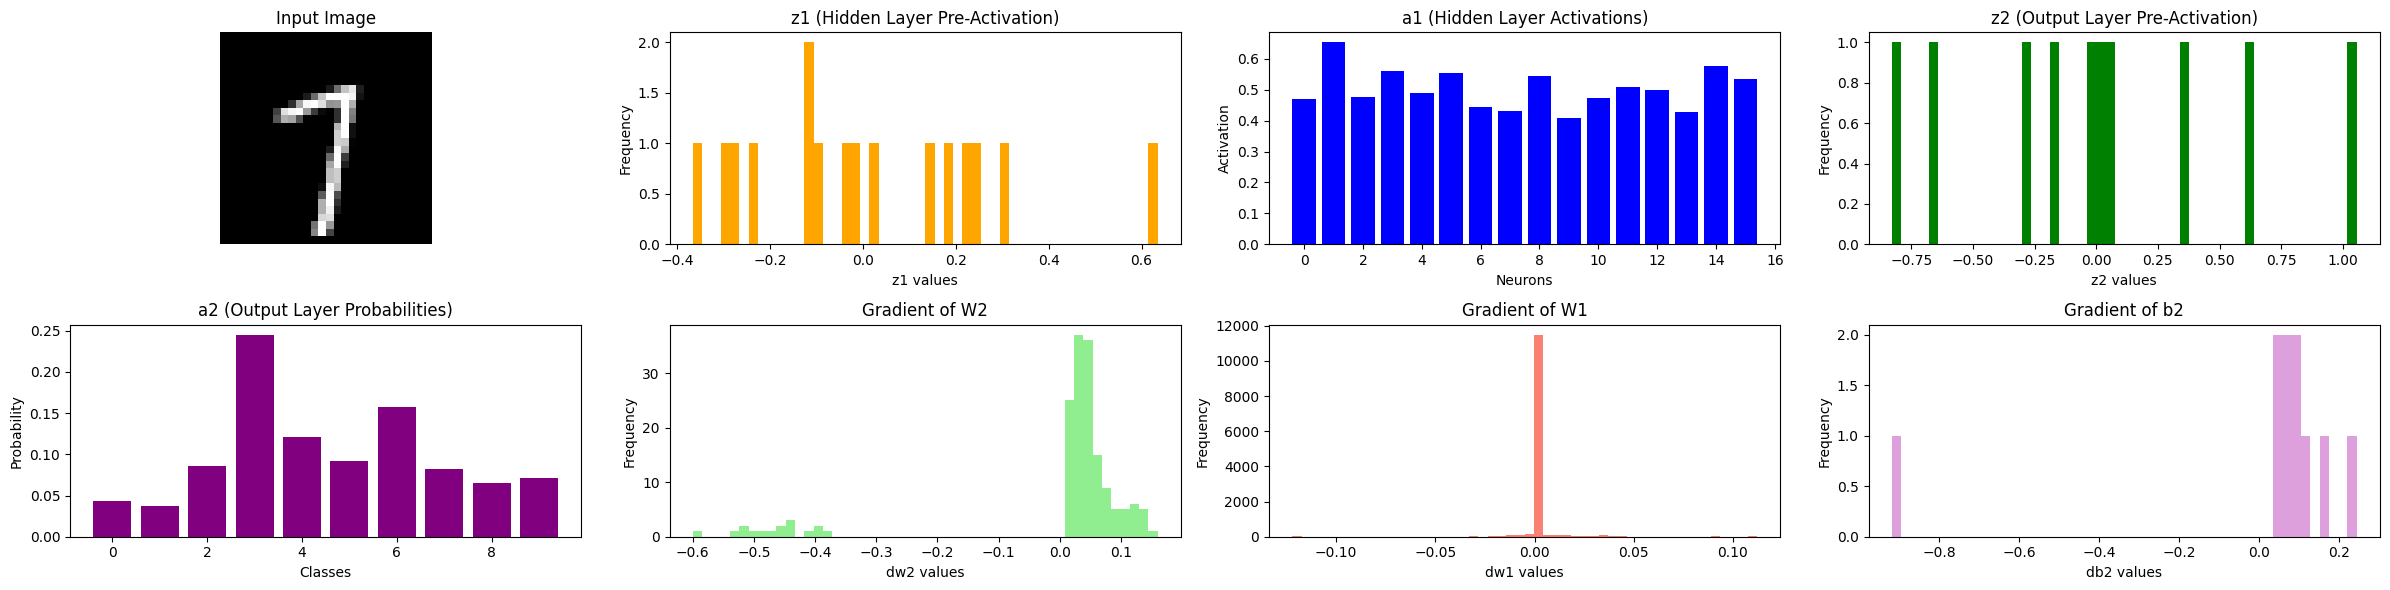

This data show the correct output because we haven't trained the network yet.


In [18]:
'''
Visualizes both forward and backward propagation for a single sample.

Parameters:
- x_sample (np.array): Single input sample (shape: input_size, 1)
- y_true (int): True label for the sample.
- weights (dict): Weight matrices.
- biases (dict): Bias vectors.

Returns:
- None
'''
def visualize_forward_backward(x_sample, y_true, weights, biases):

    # Forward propagation
    a2, cache = forward_propagation(x_sample, weights, biases)
    
    # Reshape y_true to be compatible with backpropagation (one-element array)
    y_true_array = np.array([y_true])  # Convert scalar y_true to a 1-element array
    
    # Backward propagation
    gradients = back_propagation(x_sample, y_true_array, cache, weights)
    
    # Visualization
    plt.figure(figsize=(24, 6))

    # Input Layer
    plt.subplot(2, 4, 1)
    plt.imshow(x_sample.reshape(28, 28), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # z1
    plt.subplot(2, 4, 2)
    plt.hist(cache['z1'].flatten(), bins=50, color='orange')
    plt.title('z1 (Hidden Layer Pre-Activation)')
    plt.xlabel('z1 values')
    plt.ylabel('Frequency')

    # a1
    plt.subplot(2, 4, 3)
    plt.bar(range(hidden_size), cache['a1'].flatten(), color='blue')
    plt.title('a1 (Hidden Layer Activations)')
    plt.xlabel('Neurons')
    plt.ylabel('Activation')

    # z2
    plt.subplot(2, 4, 4)
    plt.hist(cache['z2'].flatten(), bins=50, color='green')
    plt.title('z2 (Output Layer Pre-Activation)')
    plt.xlabel('z2 values')
    plt.ylabel('Frequency')

    # a2
    plt.subplot(2, 4, 5)
    plt.bar(range(output_size), cache['a2'].flatten(), color='purple')
    plt.title('a2 (Output Layer Probabilities)')
    plt.xlabel('Classes')
    plt.ylabel('Probability')

    # Gradients for W2
    plt.subplot(2, 4, 6)
    plt.hist(gradients['dw2'].flatten(), bins=50, color='lightgreen')
    plt.title('Gradient of W2')
    plt.xlabel('dw2 values')
    plt.ylabel('Frequency')

    # Gradients for W1
    plt.subplot(2, 4, 7)
    plt.hist(gradients['dw1'].flatten(), bins=50, color='salmon')
    plt.title('Gradient of W1')
    plt.xlabel('dw1 values')
    plt.ylabel('Frequency')

    # Gradients for b2
    plt.subplot(2, 4, 8)
    plt.hist(gradients['db2'].flatten(), bins=50, color='plum')
    plt.title('Gradient of b2')
    plt.xlabel('db2 values')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    print("This data show the correct output because we haven't trained the network yet.")

# Example usage:
sample_index = 42
x_sample = x_train[:, sample_index].reshape(-1, 1)
y_true = y_train[sample_index]
input_size = 784
hidden_size = 16
output_size = 10
weights, biases = initialize_parameters(input_size, hidden_size, output_size)
visualize_forward_backward(x_sample, y_true, weights, biases)


## Step 5: Parameters, Prediction, and Accuracy
---

### 5.1 Updating Parameters

Updating the weights and biases is a fundamental step in training a neural network. We'll utilize gradient descent to adjust these parameters in a direction that minimizes the cross-entropy loss function from earlier.

The `update_parameters` function updates the network's weights and biases using the gradients computed during backpropagation.

In [19]:
'''
Updates the weights and biases during learning using gradient descent.
    Subtract the product of learning_rate and gradient from current weights.
    This moves the weights in the opposite direction of the gradient, reducing loss.

Arguments:
- weights: dictionary containing the current weights w1 and w2
- biases: dictionary containing the current biases b1 and b2
- gradients: dictionary containing the gradients dw1, dw2, db1, db2 (from backpropagation)
- learning_rate: the learning rate for gradient descent (a small positive number)

Returns:
- weights: updated weights
- biases: updated biases
'''
def update_parameters(weights, biases, gradients, learning_rate):
    
    # Update weights
    weights['w1'] -= learning_rate * gradients['dw1']
    weights['w2'] -= learning_rate * gradients['dw2']

    # Update biases
    biases['b1']  -= learning_rate * gradients['db1']
    biases['b2']  -= learning_rate * gradients['db2']
    return weights, biases


#### 5.1.1 Visualizing Parameter Updates

Understanding how weights and biases change during training can provide insights into the learning process.

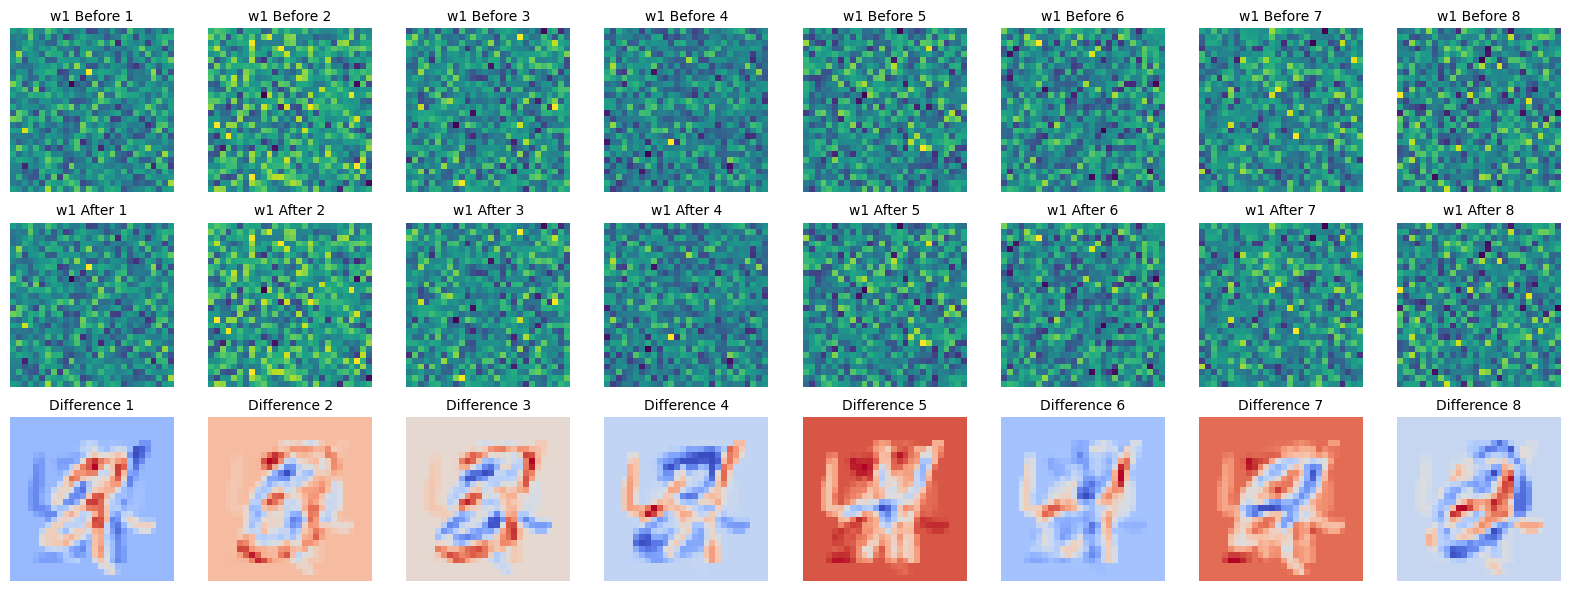

In [31]:
import copy

'''
Visualizes the changes in weights before and after updates, and the difference.

Parameters:
- weights_before (dict): Weight matrices before update.
- weights_after (dict): Weight matrices after update.
- layer (str): Which layer's weights to visualize ('w1' or 'w2').
- num_weights (int): Number of weights to visualize.

Returns:
- None
'''
def visualize_parameter_updates(weights_before, weights_after, layer='w1', num_weights=16):

    w_before = weights_before[layer]
    w_after = weights_after[layer]

    # Set up the plot grid
    fig, axes = plt.subplots(3, num_weights, figsize=(num_weights * 2, 6))

    # Before Update
    for i in range(num_weights):
        axes[0, i].imshow(w_before[i].reshape(28, 28), cmap='viridis')
        axes[0, i].set_title(f'{layer} Before {i+1}', fontsize=10)
        axes[0, i].axis('off')

    # After Update
    for i in range(num_weights):
        axes[1, i].imshow(w_after[i].reshape(28, 28), cmap='viridis')
        axes[1, i].set_title(f'{layer} After {i+1}', fontsize=10)
        axes[1, i].axis('off')

    # Difference (After - Before)
    for i in range(num_weights):
        diff = w_after[i] - w_before[i]
        axes[2, i].imshow(diff.reshape(28, 28), cmap='coolwarm')
        axes[2, i].set_title(f'Difference {i+1}', fontsize=10)
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Clone weights before update
weights_before_update = copy.deepcopy(weights)

# Perform forward and backpropagation with a batch of data
batch_size = 10
a2, cache = forward_propagation(x_train[:, :batch_size], weights, biases)
gradients = back_propagation(x_train[:, :batch_size], y_train[:batch_size], cache, weights)

# Update parameters
learning_rate = 0.1
weights, biases = update_parameters(weights, biases, gradients, learning_rate)

# Visualize updates for the hidden layer
visualize_parameter_updates(weights_before_update, weights, layer='w1', num_weights=8)


### 5.2 Making Predictions

Once the network is trained, we can use it to make predictions on new data.

The `predict` function utilizes forward propagation to compute the output probabilities and then selects the class with the highest probability as the prediction.

In [41]:
'''
Makes predictions based on the current state of the neural network.

Arguments:
- x: input data (shape: number_of_samples, input_size)
- weights: dictionary containing the current weights w1 and w2
- biases: dictionary containing the current biases b1 and b2

Returns:
- predictions: array containing predicted labels for each input
'''
def predict(x, weights, biases):
    
    # Calculate output activations
    a2, _ = forward_propagation(x, weights, biases)

    # Array containing predicted labels for each input sample
    predictions = np.argmax(a2, axis=0)

    return predictions


### 5.3 Compute Accuracy

Accuracy is a straightforward metric to evaluate how well the model performs by comparing predicted labels against true labels.

The `compute_accuracy` function calculates hte percentage of correct predictions.

In [44]:
'''
Computes the accuracy of predictions by comparing the predicted labels with the true labels.

Arguments:
- y_true: array containing the true labels for each input sample
- y_pred: array containing the predicted labels for each input sample

Returns:
- fraction of correct predictions by finding the mean of a boolean array * 100
'''
def compute_accuracy(y_true, y_pred):
    
    # Fraction of correct predictions
    return np.mean(y_true == y_pred) * 100


#### 5.3.1 Visualizing Accuracy Over Training

Monitoring accuracy alongside loss provides a comprehensive view of the model's learning progress.

* Left Plot (Loss): Shows how the cross-entropy loss decreases over epochs, indicating improving model performance.
* Right Plot (Accuracy): Illustrates the increase in accuracy as the model learns from the data.

Insights: Ideally, both loss decreases and accuracy increases, reflecting effective learning.

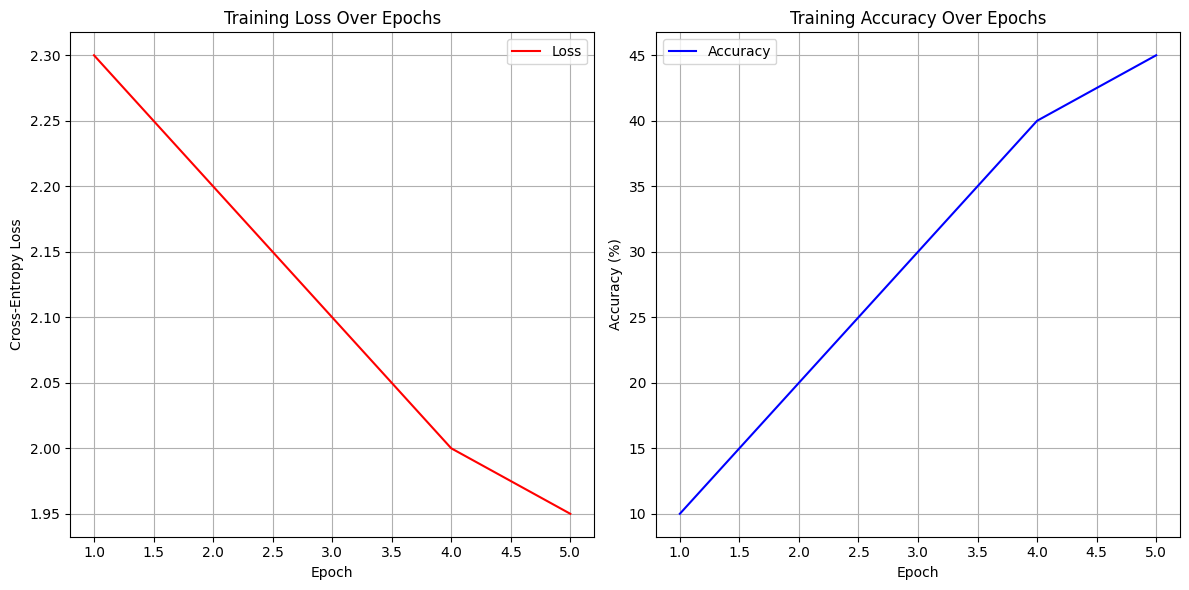

In [45]:
def plot_accuracy_over_epochs(losses, accuracies):
    """
    Plots the training loss and accuracy over epochs.

    Parameters:
        losses (list): List of loss values per epoch.
        accuracies (list): List of accuracy values per epoch.

    Returns:
        None
    """
    epochs = range(1, len(losses)+1)
    
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'r-', label='Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'b-', label='Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume we have lists 'training_losses' and 'training_accuracies' from training
training_losses = [2.3, 2.2, 2.1, 2.0, 1.95]
training_accuracies = [10, 20, 30, 40, 45]

plot_accuracy_over_epochs(training_losses, training_accuracies)
